In [ ]:
!pip install mitdeeplearning

In [ ]:
# Import Tensorflow 2.0
import tensorflow as tf 

# Download and import the MIT 6.S191 package
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import re
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
#!apt-get install abcmidi timidity > /dev/null 2>&1

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

In [ ]:
# Download the dataset
songs = mdl.lab1.load_training_data()

# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)

In [ ]:
# Convert the ABC notation to audio file and listen to it
mdl.lab1.play_song(example_song)

In [ ]:
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs) 

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")
print(songs_joined)

In [6]:
### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d", 
#   we can evaluate `char2idx["d"]`.  
char2idx = {u:i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)

print(idx2char)

['\n' ' ' '!' '"' '#' "'" '(' ')' ',' '-' '.' '/' '0' '1' '2' '3' '4' '5'
 '6' '7' '8' '9' ':' '<' '=' '>' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J'
 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' '[' ']'
 '^' '_' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p'
 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z' '|']


In [ ]:
### Vectorize the songs string ###

def vectorize_string(songs):
    numeric_rep = list()
    
    for char in songs:
        numeric_rep.append(char2idx[char])
        
    vectorized_songs = np.array(numeric_rep)
    
    return vectorized_songs

vectorized_songs = vectorize_string(songs_joined)

In [8]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))

# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:2\nT:An B' ---- characters mapped to int ----> [49 22 14  0 45 22 26 69  1 27]


In [ ]:
### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
    input_batch  = list()
    output_batch = list()
    
    # the length of the vectorized songs string
    n = vectorized_songs.shape[0] - 1
    
    # randomly choose the starting indices for the examples in the training batch
    idx = np.random.choice(n-seq_length, batch_size)
    print(idx)
    
    # Construct a list of input sequences for the training batch
    for index in idx:
        for id in range(seq_length):
            input_batch.append(vectorized_songs[id+index])
    
    # Construct a list of output sequences for the training batch
    for index in idx:
        for id in range(seq_length):
            output_batch.append(vectorized_songs[id+index+1])

    # x_batch, y_batch provide the true inputs and targets for network training
    x_batch = np.reshape(input_batch, [batch_size, seq_length])
    y_batch = np.reshape(output_batch, [batch_size, seq_length])
    
    return x_batch, y_batch

# Perform some simple tests to make sure your batch function is working properly! 
test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args): 
    print("======\n[FAIL] could not pass tests")
else: 
    print("======\n[PASS] passed all tests!")

In [ ]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

In [11]:
def LSTM(rnn_units): 
    return tf.keras.layers.LSTM(
        rnn_units, 
        return_sequences=True, 
        recurrent_initializer='glorot_uniform',
        recurrent_activation='sigmoid',
        stateful=True,
    )

In [ ]:
### Defining the RNN Model ###
dropout_rate = 0.2;

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        # Layer 1: Embedding layer to transform indices into dense vectors 
        #          of a fixed embedding size
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
        
        # Layer 2: LSTM with `rnn_units` number of units. 
        LSTM(rnn_units),
        tf.keras.layers.Dropout(dropout_rate),
        LSTM(rnn_units),
        tf.keras.layers.Dropout(dropout_rate),

        # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
        #          into the vocabulary size. 
        tf.keras.layers.Dense(vocab_size)
    ])

    return model

# Build a simple model with default hyperparameters. You will get the 
#   chance to change these later.
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

In [ ]:
model.summary()

In [ ]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)

pred = model(x)

print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

In [ ]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

In [ ]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

In [ ]:
### Defining the loss function ###

def compute_loss(labels, logits):
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    return loss

example_batch_loss = compute_loss(y, pred)

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

In [ ]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 200  # Experiment between 50 and 500
learning_rate = 1e-3  # Experiment between 1e-5 and 1e-1

# Model parameters:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 200 # Experiment between 1 and 2048

# Checkpoint location:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

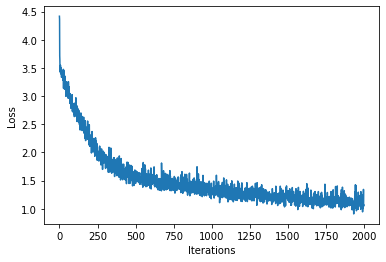

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:44<00:00, 44.52it/s]


[  7872  53318 100698 125336]
[ 18831  93993  88252 193063]


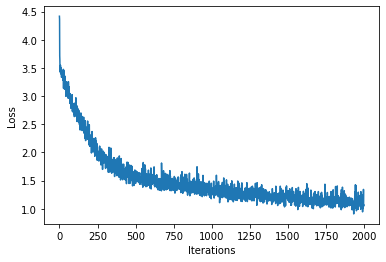

In [19]:
### Define optimizer and training operation ###

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

#optimizer = tf.keras.optimizers.Adam(learning_rate)
optimizer = tf.keras.optimizers.RMSprop(learning_rate)

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        # Feed the current input into the model and generate predictions'''
        y_hat = model(x)

        # Compute the loss!
        loss = compute_loss(y, y_hat)

    # Now, compute the gradients 
    grads = tape.gradient(loss, model.trainable_variables)

    # Apply the gradients to the optimizer so it can update the model accordingly
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):
    # Grab a batch and propagate it through the network
    x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
    loss = train_step(x_batch, y_batch)

    # Update the progress bar
    history.append(loss.numpy().mean())
    plotter.plot(history)

    # Update the model with the changed weights!
    if iter % 100 == 0:     
        model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

In [20]:
# Rebuild the model using a batch_size=1
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            21248     
_________________________________________________________________
lstm_4 (LSTM)                (1, None, 200)            365600    
_________________________________________________________________
dropout_4 (Dropout)          (1, None, 200)            0         
_________________________________________________________________
lstm_5 (LSTM)                (1, None, 200)            320800    
_________________________________________________________________
dropout_5 (Dropout)          (1, None, 200)            0         
_________________________________________________________________
dense_2 (Dense)              (1, None, 83)             16683     
Total params: 724,331
Trainable params: 724,331
Non-trainable params: 0
________________________________________________

In [ ]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
    # Evaluation step (generating ABC text using the learned RNN model)

    # Convert the start string to numbers (vectorize)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Here batch size == 1
    model.reset_states()
    tqdm._instances.clear()

    for i in tqdm(range(generation_length)):
        # Evaluate the inputs and generate the next character predictions
        predictions = model(input_eval)

        # Remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Use a multinomial distribution to sample
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the prediction along with the previous hidden state
        #   as the next inputs to the model
        input_eval = tf.expand_dims([predicted_id], 0)

        # Add the predicted character to the generated text!
        text_generated.append(idx2char[predicted_id])
        
    print(start_string + ''.join(text_generated))
    return (start_string + ''.join(text_generated))

In [24]:
start_string="X:1\nT:"
generated_text = generate_text(model, start_string, generation_length=500)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 189.00it/s]

X:1
T:Huwckartye
Z: id:dc-jig-122
M:6/8
L:1/8
K:F Minor
ABd egd|BAd AFA|B2e e2d|BdB e3|!
bag agf|edB B2d|efg edB|AGEA GEDa|!
g2fg ebab|gdfA d2ed|cAeB AFEG|Aed^c d3:|!
BdB|eAA2 BAGA|B2dB GBdB|cABG AGEG|BAGF D2:|!

X:2
T:Breell Coad
Z: id:dc-hornpipe-7
M:C|
L:1/8
K:E Dorian
E|F2aE A2FA|d2c2 B2A2|defd e2dB|cABA G3:|!
A|B4 c3|A3 B2g|a3 f3|edB AFG|!
ABc Bcd|cde fed|efg a2f|edc d2|]!

X:18
T:Jedlal Harie
Z: id:dc-reel-61
M:C
L:1/8
K:D Major
A|d2fd dBGA|GEDE FAA2|B2Bd eedB|ABAF E3:|!
d|edBG ABcA|BABA BAdB|AB


In [ ]:
generated_songs = mdl.lab1.extract_song_snippet('\n\n'+example_song+'\n\n')

for i, song in enumerate(generated_songs): 
    # Synthesize the waveform from a song
    waveform = mdl.lab1.play_song(song)
    
    # If its a valid song (correct syntax), lets play it!
    if waveform:
        print("Generated song", i)
        ipythondisplay.display(waveform)

© Alexander Amini and Ava Soleimany\
MIT 6.S191: Introduction to Deep Learning\
IntroToDeepLearning.com

Instructions for lab obtained from:\
https://github.com/aamini/introtodeeplearning/